# Tomographic Reconstruction: Total Variation regularization

Description: implementing  Total Variation (TV) regularized tomographic reconstruction using an ISTA-like optimization algorithm. It also mentions a comparison with a deep-learning-based unrolling method, for which external reconstructions are provided.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/checkpoints.zip
!mv checkpoints /content/drive/MyDrive

Archive:  /content/drive/MyDrive/checkpoints.zip
   creating: checkpoints/
  inflating: checkpoints/LPD_-15_15_angles30.pth  
  inflating: checkpoints/LPD_-30_30_angles30.pth  
mv: inter-device move failed: 'checkpoints' to '/content/drive/MyDrive/checkpoints'; unable to remove target: Directory not empty


In [9]:
!unzip /content/drive/MyDrive/MayoDataset.zip
!mv Mayo_s\ Dataset MajoDataset

import os
import shutil
from PIL import Image

# path alla cartella MajoDataset (modifica se serve)
root_dir = '/content/MajoDataset'

for split in ['train', 'test']:
    split_dir = os.path.join(root_dir, split)
    # scorri tutte le voci dentro train/ test
    for folder_name in os.listdir(split_dir):
        folder_path = os.path.join(split_dir, folder_name)
        if os.path.isdir(folder_path):
            # per ogni file nella sottocartella
            for fname in os.listdir(folder_path):
                src = os.path.join(folder_path, fname)
                # nuovo nome = nome della cartella + '_' + nome file
                new_fname = f"{folder_name}_{fname}"
                dst = os.path.join(split_dir, new_fname)
                # gestisci eventuali collisioni
                if os.path.exists(dst):
                    base, ext = os.path.splitext(new_fname)
                    i = 1
                    while True:
                        candidate = f"{base}_{i}{ext}"
                        candidate_path = os.path.join(split_dir, candidate)
                        if not os.path.exists(candidate_path):
                            dst = candidate_path
                            break
                        i += 1
                # sposta il file
                shutil.move(src, dst)

                # --- RESIZE DELL'IMMAGINE ---
                try:
                    with Image.open(dst) as img:
                        img = img.convert("RGB")  # garantiamo che sia RGB
                        img = img.resize((256, 256), Image.LANCZOS)
                        img.save(dst)
                except Exception as e:
                    print(f"Errore nel processare {dst}: {e}")

            # elimina la sottocartella vuota
            os.rmdir(folder_path)



Archive:  /content/drive/MyDrive/MayoDataset.zip
  inflating: Mayo_s Dataset/train/C004/340.png  
  inflating: Mayo_s Dataset/train/C004/333.png  
  inflating: Mayo_s Dataset/train/C004/343.png  
  inflating: Mayo_s Dataset/train/C004/338.png  
  inflating: Mayo_s Dataset/train/C004/346.png  
  inflating: Mayo_s Dataset/train/C004/347.png  
  inflating: Mayo_s Dataset/train/C004/348.png  
  inflating: Mayo_s Dataset/train/C004/354.png  
  inflating: Mayo_s Dataset/train/C004/349.png  
  inflating: Mayo_s Dataset/train/C004/342.png  
  inflating: Mayo_s Dataset/train/C004/330.png  
  inflating: Mayo_s Dataset/train/C004/335.png  
  inflating: Mayo_s Dataset/train/C004/350.png  
  inflating: Mayo_s Dataset/train/C004/357.png  
  inflating: Mayo_s Dataset/train/C004/339.png  
  inflating: Mayo_s Dataset/train/C004/325.png  
  inflating: Mayo_s Dataset/train/C004/334.png  
  inflating: Mayo_s Dataset/train/C004/352.png  
  inflating: Mayo_s Dataset/train/C004/353.png  
  inflating: Mayo_s 

In [ ]:
!pip install https://github.com/devangelista2/IPPy/archive/master.zip
!pip install astra-toolbox torch torchvision torchaudio

## Section 1: Import Libraries

  Code Comment: This cell imports necessary Python libraries for numerical operations (NumPy), plotting (Matplotlib), file system operations (os), data manipulation (Pandas), and various image processing tasks from scikit-image, including Radon and inverse Radon transforms, resizing, phantom generation, and image quality metrics (PSNR, SSIM), as well as TV denoising.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle
from PIL import Image
from IPPy.nn import models

from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

## Section 2: Helper functons

   Description: This section defines several helper functions that will be used throughout the notebook for tasks like error calculation, sinogram generation, and image reconstruction.

In [11]:
import random

def load_image_file(filepath, size=256):
    img = Image.open(filepath)
    if img.mode != 'L':
        img = img.convert('L')
    arr = np.array(img)
    resized = resize(arr, (size, size), anti_aliasing=True)
    return (resized - resized.min()) / (resized.max() - resized.min())

"""
def circular_mask(image):
    rows, cols = image.shape
    Y, X = np.ogrid[:rows, :cols]
    center = (rows/2, cols/2)
    radius = min(center)
    mask = (X-center[1])**2 + (Y-center[0])**2 <= radius**2
    return image * mask
"""

def generate_limited_angle_sinogram(image, num_angles, angle_range_deg,
                                     add_noise=False, noise_level=0.1):
    θ = np.linspace(angle_range_deg[0], angle_range_deg[1], num_angles, endpoint=True)
    sino = radon(image, theta=θ, circle=True)
    if add_noise:
        noise = np.random.normal(0, noise_level * sino.max(), sino.shape)
        sino = sino + noise
    return sino, θ

def tv_proximal_operator(image, weight):

    """
    Applies the Total Variation (TV) proximal operator, which is essentially TV denoising using the Chambolle algorithm.
    The weight parameter controls the strength of the denoising.
    """

    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)

def tv_reconstruct_ista(sinogram, theta, lamda_tv, n_iter, image_shape=None, initial_reconstruction=None):

    """
    Implements TV-regularized image reconstruction using an ISTA-like (Iterative Shrinkage-Thresholding Algorithm) optimization.
    """
    if image_shape is None:
        image_shape = (sinogram.shape[0], sinogram.shape[0])
    if initial_reconstruction is None:
        # If using default FBP initialization, mask it too.
        reconstruction = iradon(sinogram, theta=theta, output_size=image_shape[0], filter_name='ramp', circle=False)
        #reconstruction = circular_mask(reconstruction) # Mask initial FBP
    else:
        reconstruction = initial_reconstruction.copy()
        # If an initial_reconstruction is provided, it's good practice to ensure it's also masked
        # or that the calling code handles this.
        # For np.zeros_like, it's already fine.

    step_size = 0.0005  # Step size for gradient descent

    for i in range(n_iter):
        # The 'reconstruction' image from the previous step or initialization
        # is used here. It should be zero outside the circle.
        projected = radon(reconstruction, theta=theta, circle=True)
        residual = projected - sinogram
        grad = iradon(residual, theta=theta, output_size=image_shape[0], filter_name=None, circle=False)
        update = reconstruction - step_size * grad
        reconstruction = tv_proximal_operator(update, weight=lamda_tv * step_size)
        # Apply circular mask after the TV step to ensure the constraint is maintained for the next iteration
        #reconstruction = circular_mask(reconstruction)

        if (i + 1) % (n_iter // 5) == 0:
            # For calculating fidelity, use the masked reconstruction to be consistent
            # though the radon function with circle=True should primarily consider the circle.
            projected_for_fidelity = radon(reconstruction, theta=theta, circle=True)
            fidelity = 0.5 * np.linalg.norm(projected_for_fidelity - sinogram)**2
            print(f"Iter {i+1}/{n_iter} - Data Fidelity: {fidelity:.4f}")

    return reconstruction

def relative_error(true, pred):

  """
  Calculates the Frobenius norm of the difference between the true and predicted images,
  normalized by the Frobenius norm of the true image.
  This gives a measure of the relative reconstruction error.
  """

  return np.linalg.norm(true - pred, 'fro') / np.linalg.norm(true, 'fro')



# %% Dataset
class MayoDataset(Dataset):
    def __init__(self, root_dir, split, geometry, num_angles,
                 add_noise=False, noise_level=0.01, image_size=256, isEvaluation = False):
        self.files       = sorted(glob.glob(os.path.join(root_dir, split, "*.png")))
        self.geometry    = geometry
        self.num_angles  = num_angles
        self.add_noise   = add_noise
        self.noise_level = noise_level
        self.image_size  = image_size
        self.isEvaluation = isEvaluation

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 1) Ground truth (numpy array)
        img = load_image_file(self.files[idx], size=self.image_size)
        #img = circular_mask(img)

        # 2) Decidi se aggiungere rumore (solo se self.add_noise=True)
        if self.add_noise:
            # con probabilità 0.1 applico rumore
            apply_noise = (random.random() < 0.1) or self.isEvaluation
        else:
            apply_noise = False

        # 2) Sinogram (numpy array)
        sinogram, theta = generate_limited_angle_sinogram(
            image            = img,
            num_angles       = self.num_angles,
            angle_range_deg  = self.geometry,
            add_noise        = self.add_noise,
            noise_level      = self.noise_level
        )

        img_t   = torch.tensor(img,      dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        sino_t  = torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # (1,Ndet,Na)

        return sino_t, img_t



class LearnedPrimalDualNet(nn.Module):
    def __init__(self, n_iter, dual_in_ch, primal_in_ch, ippy_cfg):
        super().__init__()
        self.n_iter = n_iter

        self.dual_nets = nn.ModuleList([
            models.UNet(
                ch_in=dual_in_ch*2,    # ora concateni due feature maps sinogram-size
                ch_out=dual_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])
        self.primal_nets = nn.ModuleList([
            models.UNet(
                ch_in=primal_in_ch*2,  # concateni due feature maps image-size
                ch_out=primal_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])

    def forward(self, sino, primal0):
        # sino:   [B,1,256,30]
        # primal0:[B,1,256,256]
        dual   = sino
        primal = primal0

        for i in range(self.n_iter):
            # 1) riduco primal allo stesso “spazio” di dual → [B,1,256,30]
            primal_ds = F.interpolate(primal,
                                      size=dual.shape[-2:],
                                      mode='bilinear',
                                      align_corners=False)

            # 2) dual‑update: concateni dual e primal_ds lungo il canale
            d_in = torch.cat([dual, primal_ds], dim=1)  # [B,2,256,30]
            dual = self.dual_nets[i](d_in)              # [B,1,256,30]

            # 3) riallargo dual allo spazio dell’immagine → [B,1,256,256]
            dual_us = F.interpolate(dual,
                                    size=primal.shape[-2:],
                                    mode='bilinear',
                                    align_corners=False)

            # 4) primal‑update: concateni primal e dual_us
            p_in = torch.cat([primal, dual_us], dim=1)  # [B,2,256,256]
            primal = self.primal_nets[i](p_in)          # [B,1,256,256]

        return primal

## Section 3: Defining parameters:

Description: This section initializes various parameters that will control the CT simulation and reconstruction process.

In [50]:
image_size = 256



lambda_tv_ista = 0.05
n_iterations_ista = 1000
num_angles = 30
noise_level = 0.1
geometries = [(-30, 30), (-15, 15)]
noise_flags = [False, True] #nella geometria -15 15 metto il flag noise a true (generera' rumore solo a 1/3 di immagini) per vedere poi in inferenza quanto sara' robusto al rumore
zoom_coords = (slice(40, 80), slice(40, 80))


drive.mount('/content/drive')
CKPT_DIR = '/content/drive/MyDrive/checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# %% Parametri globali
batch_size       = 4
num_workers      = 0
pin_memory       = True

# %% Configurazione IPPy U‑Net
N_FEATURES             = 32
N_DUAL                 = 1
ippy_middle_ch         = [N_FEATURES, N_FEATURES * 2]
ippy_down_layers       = ["ResDownBlock"]
ippy_up_layers         = ["ResUpBlock"]
ippy_n_layers_per_block= 2

ippy_cfg = {
    'middle_ch':          ippy_middle_ch,
    'down_layers':        ippy_down_layers,
    'up_layers':          ippy_up_layers,
    'n_layers_per_block': ippy_n_layers_per_block
}

print("UNet config:", ippy_cfg)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
UNet config: {'middle_ch': [32, 64], 'down_layers': ['ResDownBlock'], 'up_layers': ['ResUpBlock'], 'n_layers_per_block': 2}


In [ ]:
# ------------------------------------
# |           TRAINING               |
# ------------------------------------

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

# Parametri
N_ITER        = 10
primal_in_ch  = 1
epochs        = 50
max_batches   = 20   # solo per debugging
batch_size    = 4
num_workers   = 2
pin_memory    = True
learning_rate = 1e-4

for geom, noise_flag in zip(geometries, noise_flags):


    print(f'traino la geometria {geom} con noise flag {noise_flag}')
    # --- Dataloader train e val ---
    train_ds = MayoDataset("/content/MajoDataset", "train", geom,
                           num_angles, noise_flag, noise_level, image_size)
    train_loader = DataLoader(train_ds, batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)

    val_ds = MayoDataset("/content/MajoDataset", "test", geom,
                         num_angles, noise_flag, noise_level, image_size)
    val_loader = DataLoader(val_ds, batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)

    # --- Modello, ottim, loss ---
    net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn   = nn.MSELoss()

    # --- Preparazione checkpoint/resume ---
    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )
    start_epoch    = 1
    best_psnr     = 0.0
    best_val_loss  = float('inf')
    if os.path.isfile(ckpt_file):
        ckpt = torch.load(ckpt_file)
        net.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['opt'])
        start_epoch   = ckpt['epoch'] + 1
        best_val_loss = ckpt['best_val_loss']
        best_psnr     = ckpt.get('best_psnr', 0.0)
        print(f">> Riprendo da epoca {start_epoch} con best_val_loss={best_val_loss:.4f}")

    # --- Loop epoche ---
    net.train()
    for epoch in range(start_epoch, epochs + 1):
        print(f'epoca {epoch}')
        total_loss = 0.0
        num_seen   = 0

        epoch_start = time.perf_counter()

        # TRAIN (puoi togliere max_batches per run completo)
        for batch_idx, (sino, gt) in enumerate(train_loader):
            sino, gt = sino.cuda(), gt.cuda()
            primal0  = torch.zeros_like(gt)

            out = net(sino, primal0)
            loss = loss_fn(out, gt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = sino.size(0)
            total_loss += loss.item() * bs
            num_seen   += bs


            #if batch_idx + 1 >= max_batches:
            #    break

        train_loss = total_loss / num_seen
        print(f"[Train] Geom {geom}, Ep {epoch:02d}, Loss={train_loss:.4f}")

        # VALIDATION
        net.eval()
        val_loss_sum = 0.0
        val_psnr_sum = 0.0
        val_samples  = 0
        with torch.no_grad():
            for sino_v, gt_v in val_loader:
                sino_v, gt_v = sino_v.cuda(), gt_v.cuda()
                primal0_v    = torch.zeros_like(gt_v)

                out_v = net(sino_v, primal0_v)
                l_v   = loss_fn(out_v, gt_v)

                # Accumulo per la loss
                bs = sino_v.size(0)
                val_loss_sum += l_v.item() * bs

                # Calcolo PSNR su ciascun sample
                for b in range(bs):
                    rec_np = np.array(out_v[b,0].cpu().tolist(), dtype=np.float32)
                    gt_np  = np.array(gt_v[b,0].cpu().tolist(),     dtype=np.float32)
                    val_psnr_sum += psnr(gt_np, rec_np, data_range=1.0)
                    val_samples  += 1

        # Media
        val_loss = val_loss_sum / (val_samples)
        val_psnr = val_psnr_sum / val_samples

        epoch_time = time.perf_counter() - epoch_start
        print(f"[ Val ] Geom {geom}, Ep {epoch:02d}, ValLoss={val_loss:.4f}, ValPSNR={val_psnr:.2f}")
        print(f"--> Tempo impiegato per epoca {epoch:02d}: {epoch_time:.2f} secondi")

        # Salva checkpoint se migliora
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = min(val_loss, best_val_loss)
            best_psnr     = max(val_psnr, best_psnr)

            torch.save({
                'epoch':         epoch,
                'model':         net.state_dict(),
                'opt':           optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_psnr':     best_psnr
            }, ckpt_file)
            print(f">> Nuovo best! Checkpoint salvato a epoca {epoch}")

        net.train()

    print(f">> Fine training Geom {geom}. Best ValLoss={best_val_loss:.4f}, Best PSNR={best_psnr:.2f}\n")


traino la geometria (-30, 30) con noise flag False
>> Riprendo da epoca 9 con best_val_loss=0.0133
epoca 9
[Train] Geom (-30, 30), Ep 09, Loss=0.0071
[ Val ] Geom (-30, 30), Ep 09, ValLoss=0.0160, ValPSNR=18.26
--> Tempo impiegato per epoca 09: 1262.84 secondi
epoca 10
[Train] Geom (-30, 30), Ep 10, Loss=0.0064
[ Val ] Geom (-30, 30), Ep 10, ValLoss=0.0144, ValPSNR=18.74
--> Tempo impiegato per epoca 10: 1261.35 secondi
epoca 11
[Train] Geom (-30, 30), Ep 11, Loss=0.0061
[ Val ] Geom (-30, 30), Ep 11, ValLoss=0.0164, ValPSNR=18.20
--> Tempo impiegato per epoca 11: 1261.10 secondi
epoca 12
[Train] Geom (-30, 30), Ep 12, Loss=0.0057
[ Val ] Geom (-30, 30), Ep 12, ValLoss=0.0181, ValPSNR=17.67
--> Tempo impiegato per epoca 12: 1259.17 secondi
epoca 13
[Train] Geom (-30, 30), Ep 13, Loss=0.0054
[ Val ] Geom (-30, 30), Ep 13, ValLoss=0.0156, ValPSNR=18.43
--> Tempo impiegato per epoca 13: 1260.46 secondi
epoca 14
[Train] Geom (-30, 30), Ep 14, Loss=0.0050
[ Val ] Geom (-30, 30), Ep 14, ValL

KeyboardInterrupt: 

## Section 5: Evaluate results

Description: This section iterates through different CT geometries (angle ranges) and noise conditions. For each combination, it generates a sinogram, performs reconstructions using FBP and TV-ISTA, calculates image quality metrics (Relative Error, PSNR, SSIM), and displays the original image alongside the FBP and TV-ISTA reconstructions, both full and zoomed views. The resulting plots are saved as PNG files.

In [51]:
# Definiamo 4 diverse zone di zoom
zoom_coords_list = [
    (slice(70, 110), slice(130, 180)),
    (slice(80, 120), slice(80, 130)),
    (slice(145, 185), slice(100, 150))
]

N_ITER        = 10
primal_in_ch  = 1

net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Iter 200/1000 - Data Fidelity: 7819.6122
Iter 400/1000 - Data Fidelity: 4912.4129
Iter 600/1000 - Data Fidelity: 3864.7898
Iter 800/1000 - Data Fidelity: 3248.3613
Iter 1000/1000 - Data Fidelity: 2799.3022
Saved plot: /content/drive/MyDrive/plots/plot_geom_-30_30_no_noise.png
Iter 200/1000 - Data Fidelity: 60311.9861
Iter 400/1000 - Data Fidelity: 36234.5117
Iter 600/1000 - Data Fidelity: 27900.7165
Iter 800/1000 - Data Fidelity: 24184.0743
Iter 1000/1000 - Data Fidelity: 22224.7228
Saved plot: /content/drive/MyDrive/plots/plot_geom_-30_30_noise.png
Iter 200/1000 - Data Fidelity: 5082.1121
Iter 400/1000 - Data Fidelity: 3245.2309
Iter 600/1000 - Data Fidelity: 2420.5240
Iter 800/1000 - Data Fidelity: 1921.4868
Iter 1000/1000 - Data Fidelity: 1587.2593
Saved plot: /content/drive/MyDrive/plots/plot_geom_-15_15_no_noise.png
Iter 200/1000 - Data Fidelity: 68073.5756
Iter 400/1000 - Data Fidelity: 48011.3376
Iter 600/1000 - Data Fidelity: 40447.4733
Iter 800/1000 - Data Fidelity: 36804.1167

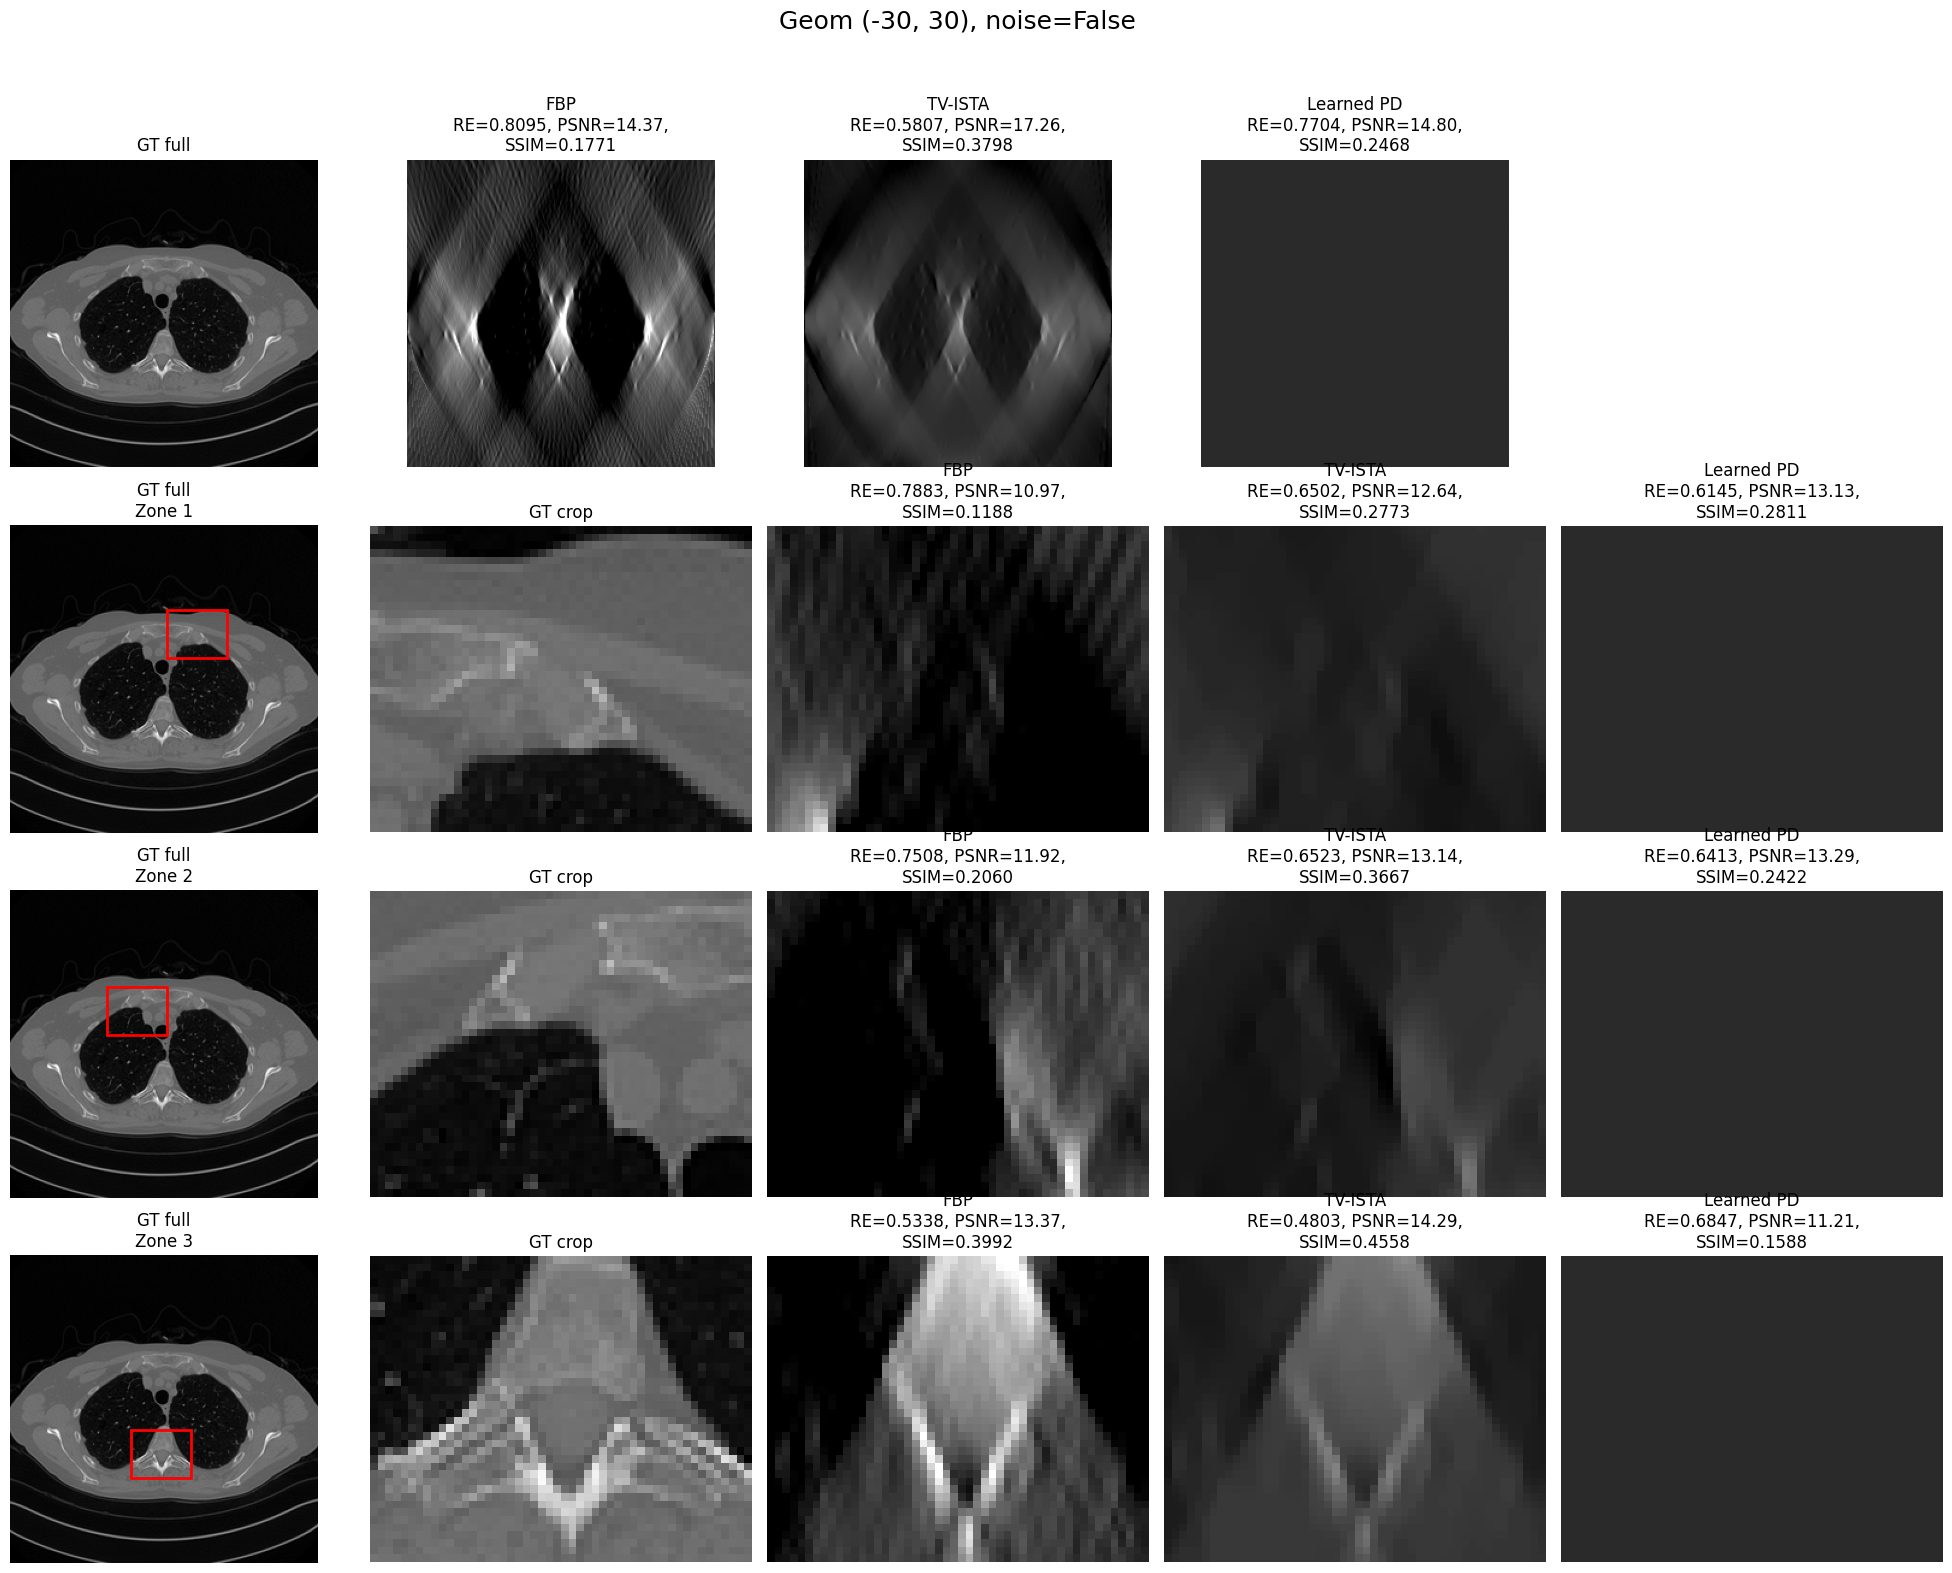

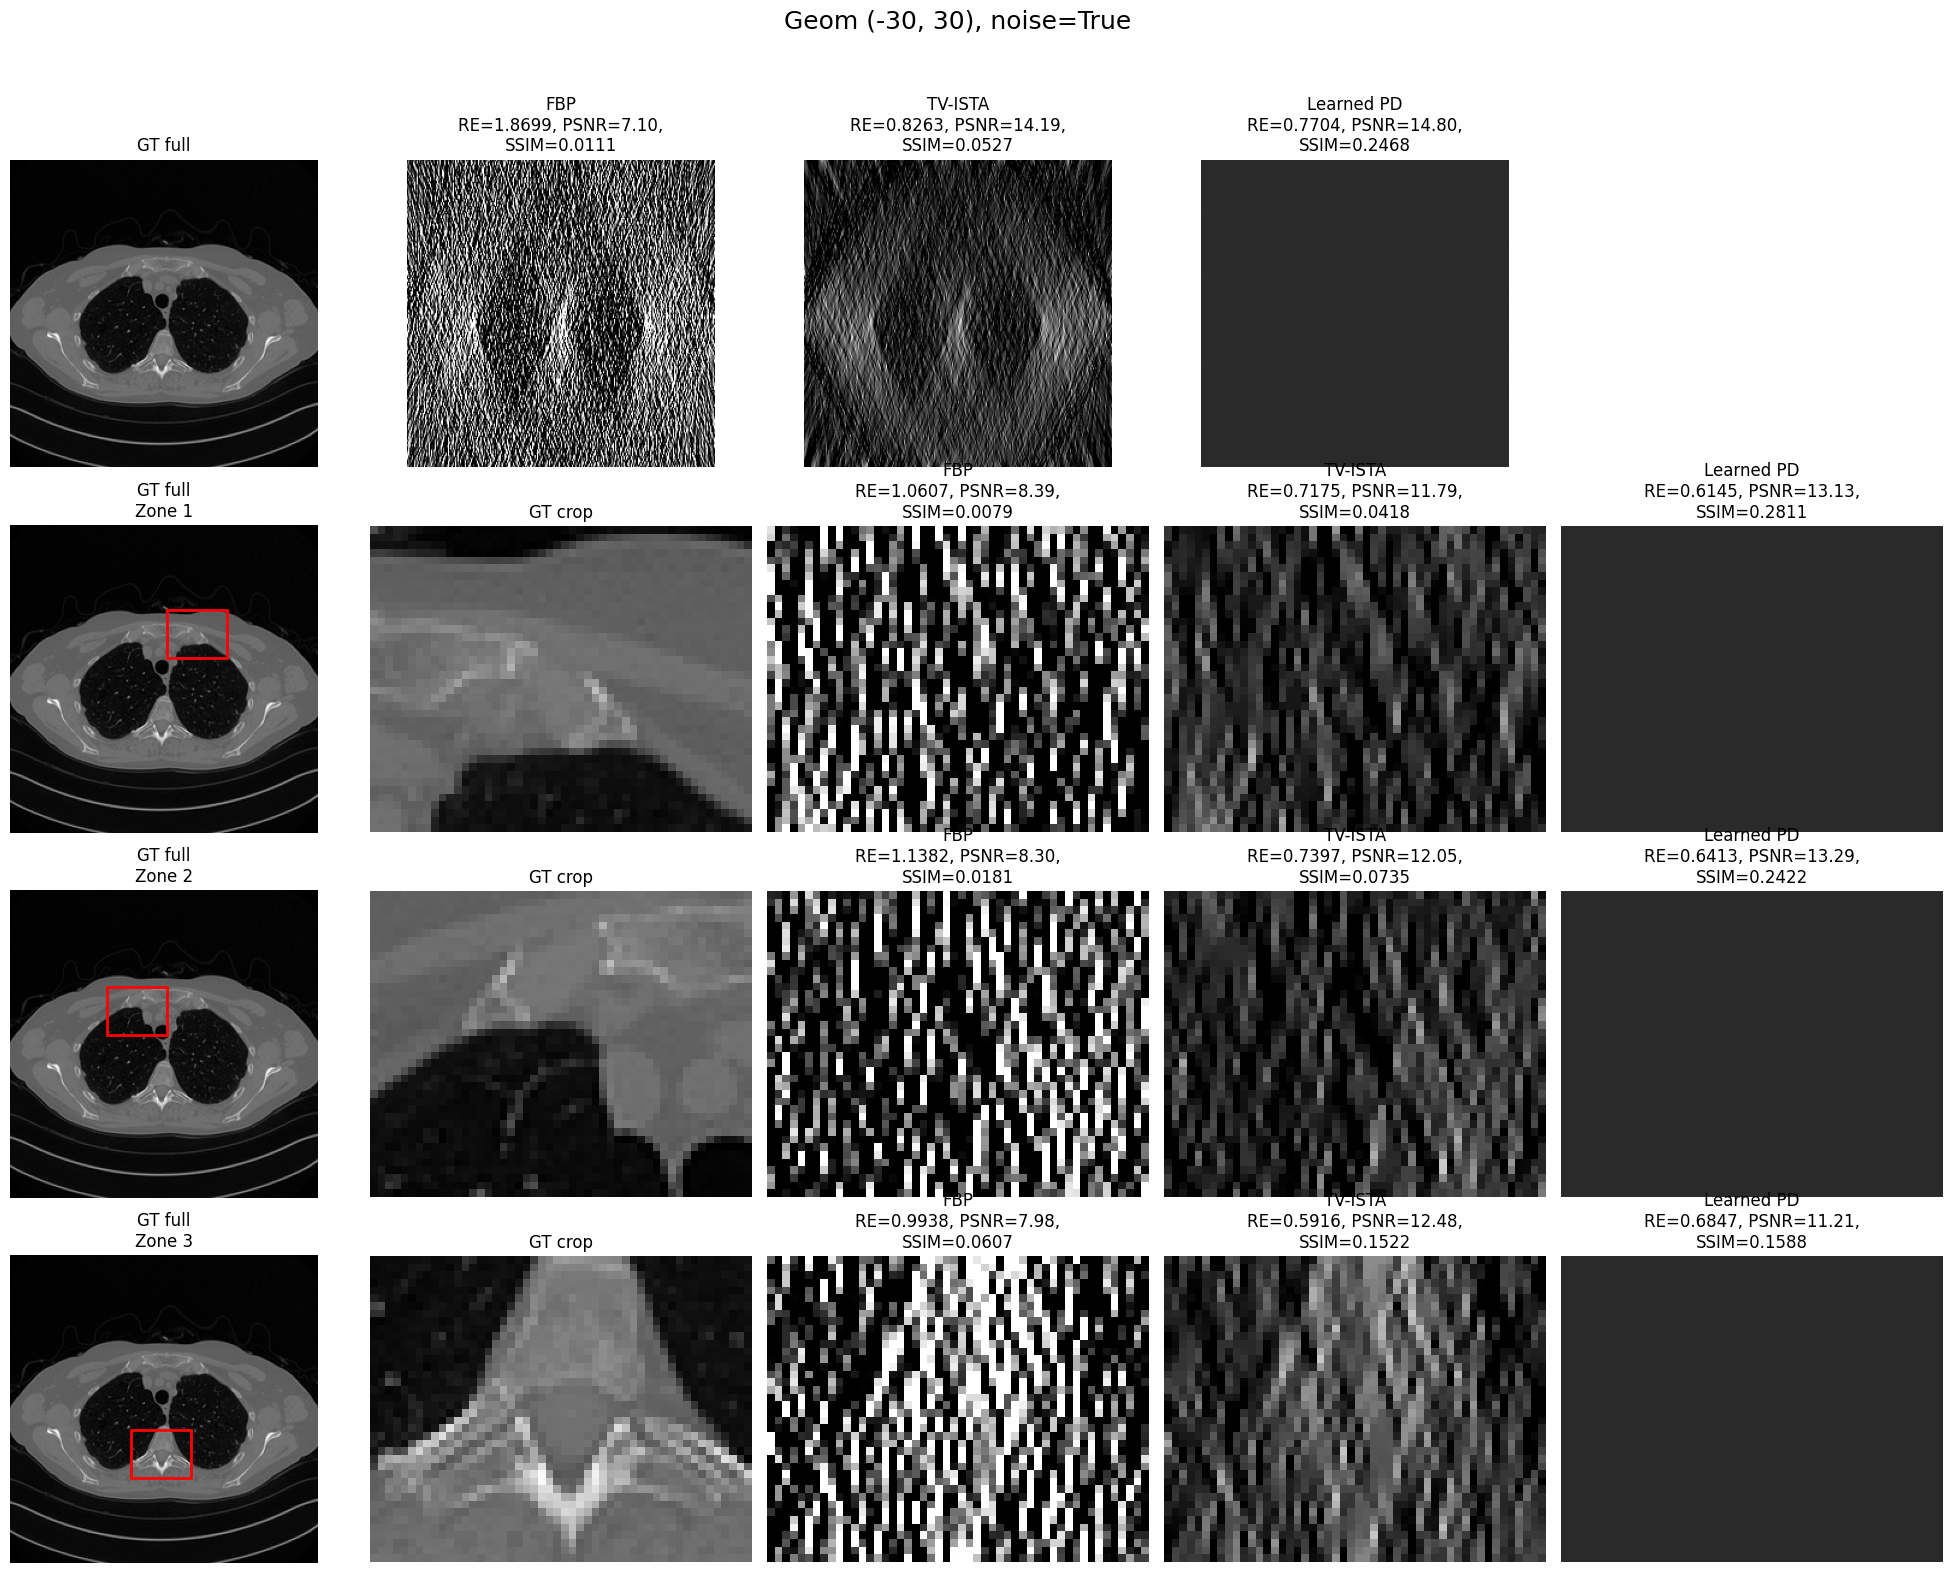

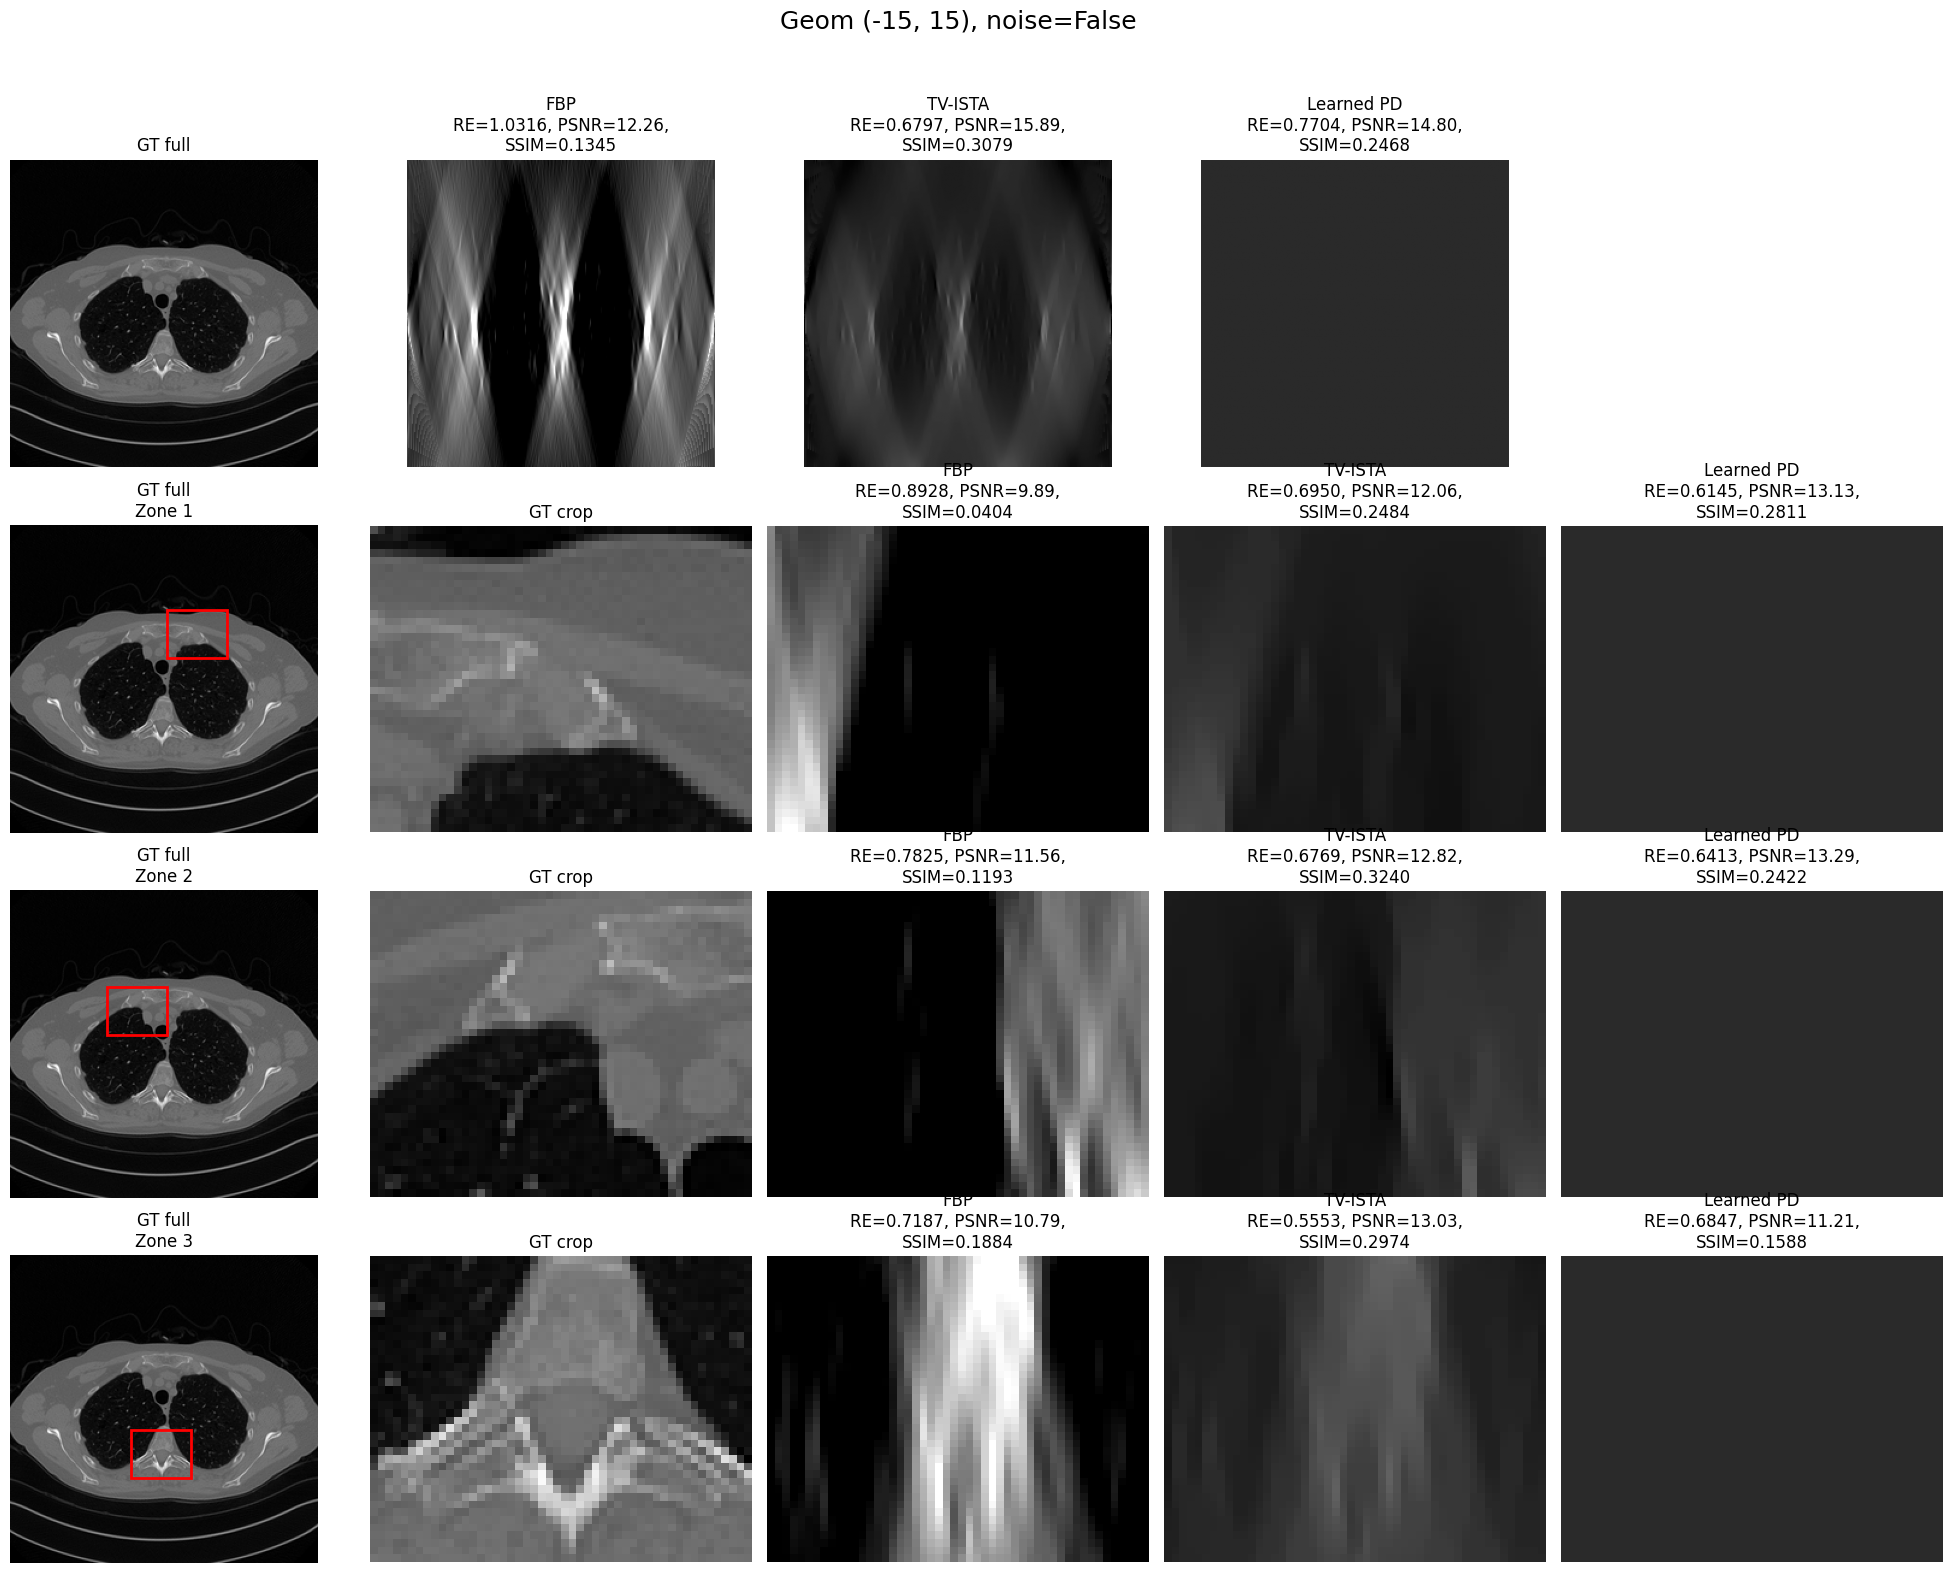

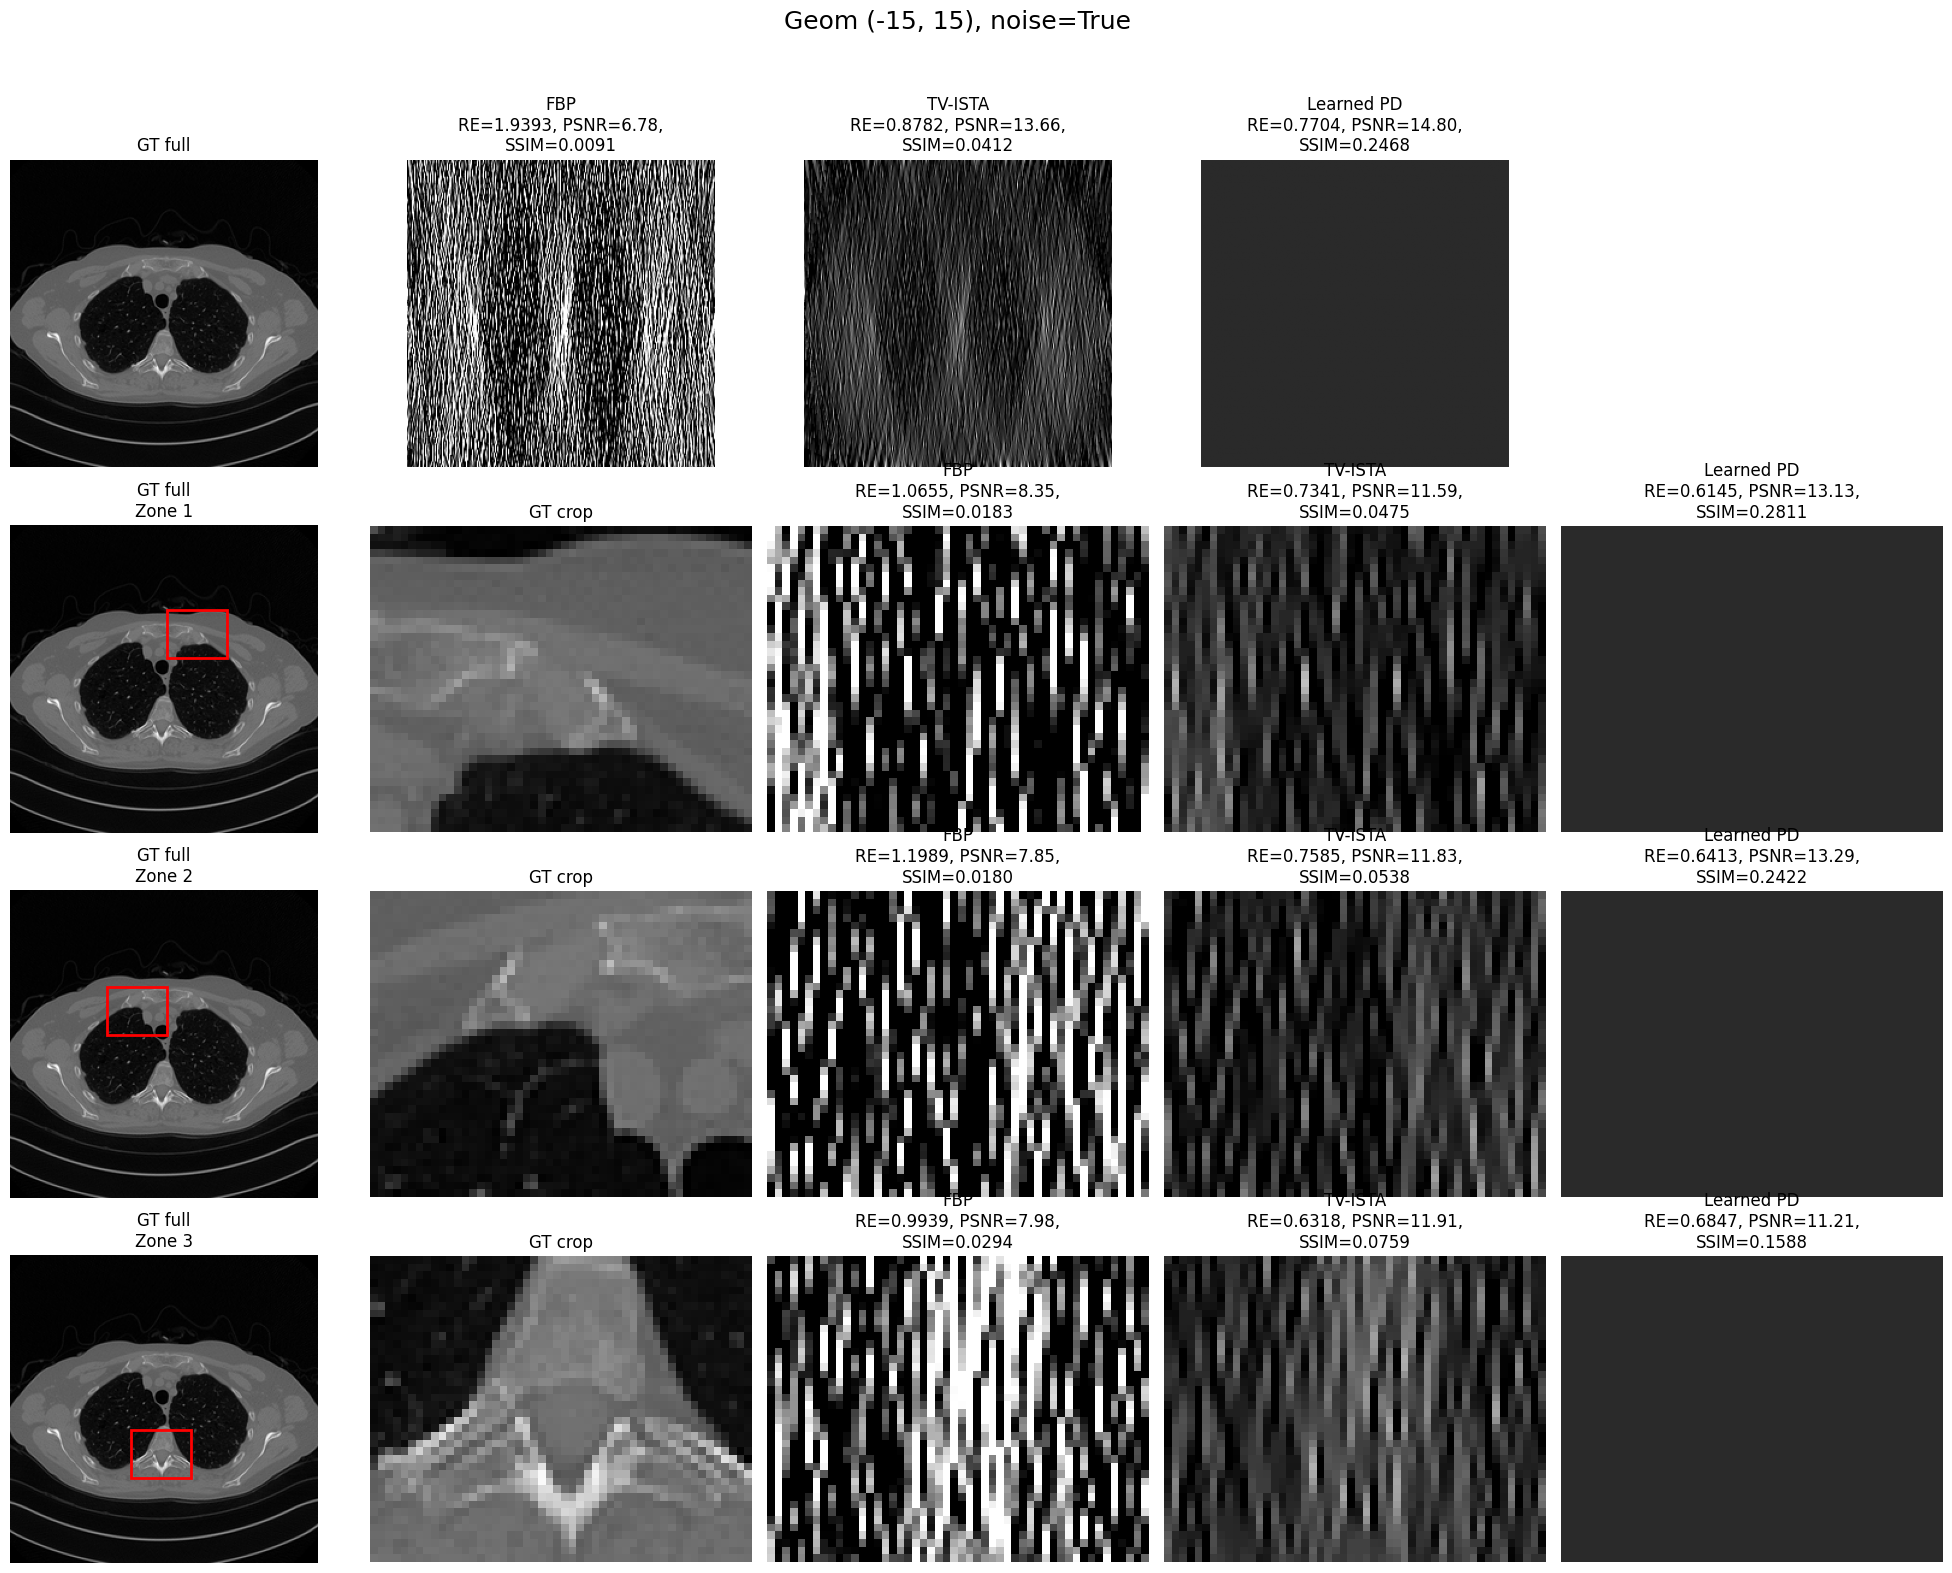

In [52]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from itertools import product
import torch
from torch.utils.data import DataLoader

# Mount Google Drive
drive.mount('/content/drive')

# Directory to save plots
save_dir = '/content/drive/MyDrive/plots'
os.makedirs(save_dir, exist_ok=True)

net.eval()

for geom, noise_flag in product(geometries, noise_flags):

    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )

    ckpt = torch.load(ckpt_file)
            net.load_state_dict(ckpt['model'])

    # Load one sample for illustration

    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size,
        isEvaluation = True
    )
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    sino_t, img_t = next(iter(test_loader))
    sino_t, img_t = sino_t.cuda(), img_t.cuda()

    # Convert to numpy
    sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
    orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)
    theta   = np.linspace(geom[0], geom[1], num_angles, endpoint=True)

    # Reconstructions
    fbp = iradon(sino_np, theta=theta, output_size=image_size,
                 filter_name='ramp', circle=False)
    fbp = np.clip(fbp, 0, 1)

    ista = tv_reconstruct_ista(
        sinogram               = sino_np,
        theta                  = theta,
        lamda_tv               = lambda_tv_ista,
        n_iter                 = n_iterations_ista,
        image_shape            = orig_np.shape,
        initial_reconstruction = np.zeros(orig_np.shape)
    )
    ista = np.clip(ista, 0, 1)

    with torch.no_grad():
        out = net(sino_t, torch.zeros_like(img_t))
    lpd_np = np.clip(np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32), 0, 1)

    recs = [orig_np, fbp, ista, lpd_np]
    methods = ["Ground Truth", "FBP", "TV-ISTA", "Learned PD"]

    # Plot full images + zoomed patches
    n_zoom = len(zoom_coords_list)
    fig, axs = plt.subplots(n_zoom + 1, 5, figsize=(20, 4*(n_zoom + 1)))

    # === Row 0: full images ===
    ax = axs[0, 0]
    ax.imshow(orig_np, cmap='gray', vmin=0, vmax=1)
    ax.set_title("GT full")
    ax.axis('off')

    for mi, (rec, method) in enumerate(zip(recs[1:], methods[1:]), start=1):
        re_full   = relative_error(orig_np, rec)
        psnr_full = psnr(orig_np, rec, data_range=1.0)
        ssim_full = ssim(orig_np, rec, data_range=1.0, channel_axis=None)

        ax = axs[0, mi]
        ax.imshow(rec, cmap='gray', vmin=0, vmax=1)
        ax.set_title(
            f"{method}\nRE={re_full:.4f}, PSNR={psnr_full:.2f},\nSSIM={ssim_full:.4f}"
        )
        ax.axis('off')

    # Blank last cell in row 0
    ax = axs[0, 4]
    ax.axis('off')

    # === Zoom rows ===
    for zi, zoom_coords in enumerate(zoom_coords_list, start=1):
        y_slice, x_slice = zoom_coords
        y0, y1 = y_slice.start, y_slice.stop
        x0, x1 = x_slice.start, x_slice.stop
        width, height = x1 - x0, y1 - y0

        # 1) Full GT with red rectangle
        ax = axs[zi, 0]
        ax.imshow(orig_np, cmap='gray', vmin=0, vmax=1)
        rect = Rectangle((x0, y0), width, height,
                         edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.set_title(f"GT full\nZone {zi}")
        ax.axis('off')

        # 2) GT crop
        gt_crop = orig_np[zoom_coords]
        ax = axs[zi, 1]
        ax.imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
        ax.set_title("GT crop")
        ax.axis('off')

        # 3–5) reconstructions crop + metrics
        for mi, (rec, method) in enumerate(zip(recs[1:], methods[1:]), start=2):
            crop = rec[zoom_coords]
            re_z   = relative_error(gt_crop, crop)
            psnr_z = psnr(gt_crop, crop, data_range=1.0)
            ssim_z = ssim(gt_crop, crop, data_range=1.0, channel_axis=None)

            ax = axs[zi, mi]
            ax.imshow(crop, cmap='gray', vmin=0, vmax=1)
            ax.set_title(
                f"{method}\nRE={re_z:.4f}, PSNR={psnr_z:.2f},\nSSIM={ssim_z:.4f}"
            )
            ax.axis('off')

    fig.suptitle(f"Geom {geom}, noise={noise_flag}", fontsize=18)
    plt.tight_layout(rect=[0,0,1,0.96])

    # Save figure to Drive
    geom_str = f"{int(geom[0])}_{int(geom[1])}"
    noise_str = 'noise' if noise_flag else 'no_noise'
    filename = f"plot_geom_{geom_str}_{noise_str}.png"
    filepath = os.path.join(save_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')

    print(f"Saved plot: {filepath}")


In [ ]:
import pandas as pd
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import torch
from torch.utils.data import DataLoader
from itertools import product


# Parametri generali
MAX_SAMPLES_PER_CONDITION = 20
methods = ["FBP", "TV-ISTA", "Learned PD"]
metric_names = ["RE", "PSNR", "SSIM"]
zones = ["Full"] + [f"Zoom{i+1}" for i in range(len(zoom_coords_list))]


# Lista per raccogliere tutte le righe finali
all_table_rows = []

net.eval()

# Loop su tutte le combinazioni (4 condizioni)
for geom, noise_flag in product(geometries, noise_flags):

    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )

    ckpt = torch.load(ckpt_file)
            net.load_state_dict(ckpt['model'])

    geom_str = f"{abs(geom[0])}-{abs(geom[1])}"
    noise_str = "TRUE" if noise_flag else "FALSE"

    # Inizializza dizionario metriche per questa condizione
    metrics = {m: {z: {k: [] for k in metric_names} for z in zones} for m in methods}

    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size,
        isEvaluation = True
    )
    test_loader = DataLoader(
        test_ds,
        batch_size = 1,
        shuffle    = False,
        num_workers= num_workers,
        pin_memory = pin_memory
    )

    theta = np.linspace(geom[0], geom[1], num_angles, endpoint=True)

    sample_count = 0
    for sino_t, img_t in test_loader:
        if sample_count >= MAX_SAMPLES_PER_CONDITION:
            break
        sample_count += 1

        sino_t, img_t = sino_t.cuda(), img_t.cuda()
        sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
        orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)

        # FBP
        fbp = iradon(sino_np, theta=theta, output_size=image_size,
                     filter_name='ramp', circle=False)
        fbp = np.clip(fbp, 0, 1)

        # TV‑ISTA
        ista = tv_reconstruct_ista(
            sinogram               = sino_np,
            theta                  = theta,
            lamda_tv               = lambda_tv_ista,
            n_iter                 = n_iterations_ista,
            image_shape            = orig_np.shape,
            initial_reconstruction = np.zeros(orig_np.shape)
        )
        ista = np.clip(ista, 0, 1)

        # Learned Primal‑Dual
        with torch.no_grad():
            out = net(sino_t, torch.zeros_like(img_t))
        lpd_np = np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32)
        lpd_np = np.clip(lpd_np, 0, 1)

        # Lista di ricostruzioni e metodi
        recs = [fbp, ista, lpd_np]
        for rec, method in zip(recs, methods):
            # Full metrics
            re_val   = relative_error(orig_np, rec)
            psnr_val = psnr(orig_np, rec, data_range=1.0)
            ssim_val = ssim(orig_np, rec, data_range=1.0, channel_axis=None)

            metrics[method]["Full"]["RE"].append(re_val)
            metrics[method]["Full"]["PSNR"].append(psnr_val)
            metrics[method]["Full"]["SSIM"].append(ssim_val)

            # Zoom metrics
            for i, zoom_coords in enumerate(zoom_coords_list):
                gt_crop  = orig_np[zoom_coords]
                rec_crop = rec[zoom_coords]

                re_z   = relative_error(gt_crop, rec_crop)
                psnr_z = psnr(gt_crop, rec_crop, data_range=1.0)
                ssim_z = ssim(gt_crop, rec_crop, data_range=1.0, channel_axis=None)

                zone_name = f"Zoom{i+1}"
                metrics[method][zone_name]["RE"].append(re_z)
                metrics[method][zone_name]["PSNR"].append(psnr_z)
                metrics[method][zone_name]["SSIM"].append(ssim_z)

    # Costruzione righe tabella per questa condizione
    for method in methods:
        row = {
            "Method": method,
            "Geometry": geom_str,
            "Noise": noise_str,
            "N Samples": sample_count
        }
        for zone in zones:
            for metric in metric_names:
                values = metrics[method][zone][metric]
                mean_val = np.mean(values)
                if metric == "PSNR":
                    row[f"{metric} ({zone})"] = f"{mean_val:.2f}"
                else:
                    row[f"{metric} ({zone})"] = f"{mean_val:.4f}"
        all_table_rows.append(row)

# Crea DataFrame unico
df_all = pd.DataFrame(all_table_rows)

# Stampa a schermo
print(df_all.to_string(index=False))

# Salva su Google Drive
output_filename = "/content/drive/MyDrive/metrics_summary_all_conditions.xlsx"
df_all.to_excel(output_filename, index=False)
print(f"\nTabella salvata in file: {output_filename}")


Iter 200/1000 - Data Fidelity: 7819.6122
Iter 400/1000 - Data Fidelity: 4912.4129
Iter 600/1000 - Data Fidelity: 3864.7898
Iter 800/1000 - Data Fidelity: 3248.3613
Iter 1000/1000 - Data Fidelity: 2799.3022
Iter 200/1000 - Data Fidelity: 9694.5476
Iter 400/1000 - Data Fidelity: 6780.2331
Iter 600/1000 - Data Fidelity: 5563.1381
Iter 800/1000 - Data Fidelity: 4779.2253
Iter 1000/1000 - Data Fidelity: 4168.1726
Iter 200/1000 - Data Fidelity: 6633.7612
Iter 400/1000 - Data Fidelity: 4102.4389
Iter 600/1000 - Data Fidelity: 3211.8613
Iter 800/1000 - Data Fidelity: 2694.2448
Iter 1000/1000 - Data Fidelity: 2319.8552
Iter 200/1000 - Data Fidelity: 5493.7125
Iter 400/1000 - Data Fidelity: 3255.1914
Iter 600/1000 - Data Fidelity: 2545.6514
Iter 800/1000 - Data Fidelity: 2148.3981
Iter 1000/1000 - Data Fidelity: 1863.7395
Iter 200/1000 - Data Fidelity: 9573.7412
Iter 400/1000 - Data Fidelity: 6209.1994
Iter 600/1000 - Data Fidelity: 4937.3059
Iter 800/1000 - Data Fidelity: 4165.8958
Iter 1000/10